## Convolutional Neural Network

## Split data

In [1]:
import itertools    
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat
import pathlib
import sklearn.datasets
from sklearn.model_selection import train_test_split

import copy
from PIL import Image

import glob

import pathlib

data_dir = pathlib.Path('./dataset')


image_count = len(list(data_dir.glob('*/*.*')))
print("Total no of images =", image_count)

images = []
labels = []
classes = set()

image_width = 30
image_height = 30

for filename in data_dir.glob('*/*.*'):
    class_name = str(filename).split("/")[1]
    classes.add(class_name)
    im=copy.deepcopy(Image.open(filename).resize((image_width,image_height)).convert('LA'))
    #print(np.array(im).shape)
    images.append(np.array(im)[...,:1].reshape((image_width*image_height*1,)))
    #print(images[0].shape)
    labels.append(class_name)
    im.close()

classes = sorted(list(classes))
labels = [i for x in labels for i in range(len(classes)) if x == classes[i]]




INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Total no of images = 9008


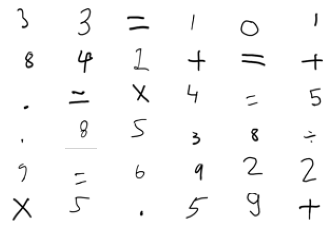

In [2]:
import random

for i,j in enumerate(random.sample(range(len(images)), 36)):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[j].reshape(image_width,image_height,), cmap='gray')
    #plt.title(classes[labels[j]])
    plt.axis("off")


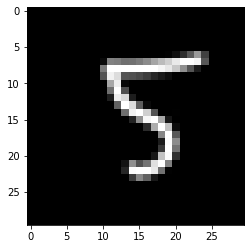

In [3]:
dataX = np.array(images).reshape((len(images), images[0].shape[0]))

#dataX[dataX <  128] = 0
#dataX[dataX >= 128] = 1
dataX = 1 - dataX / 255

plt.imshow(dataX[0].reshape(image_width, image_height), cmap="gray")

dataY = np.array(labels).reshape((len(labels),1))

In [4]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# train is now 60% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

#print(x_train, x_val, x_test)

In [5]:
num_classes = 16
img_channels = 1


#Defining the Convolutional Neural Network
model = Sequential([
    layers.Conv2D(64, 3, input_shape = (image_width,image_height,img_channels)),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(128, (3, 3), input_shape = (image_width,image_height,img_channels), activation='relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),

    layers.Flatten(),
    layers.Dropout(.2),
    layers.Dense(units = 120, activation='relu'),
    layers.Dense(units = num_classes, activation='softmax'),
])
# After defining our model, we will check the model by its summary.

model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])

#CNN Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               5

In [6]:
epochs = 20

history = model.fit(
  x_train.reshape(len(x_train), image_width, image_height, 1),
  y_train,
  validation_data=(x_val.reshape(len(x_val), image_width, image_height, 1), y_val),
  epochs=epochs
)


169/169 [==============================] - 9s 50ms/step - loss: 1.8682 - accuracy: 0.4222 - val_loss: 0.5628 - val_accuracy: 0.8291


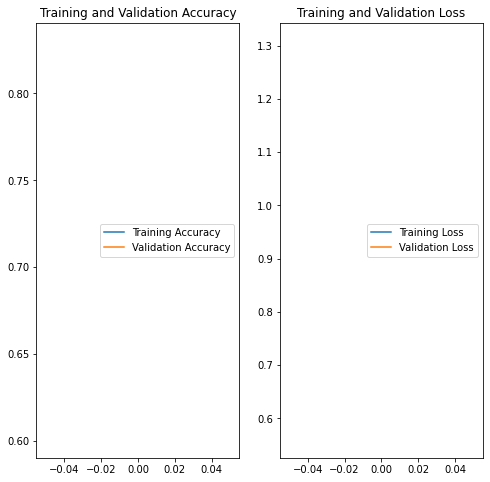

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [8]:
score = model.evaluate(x_test.reshape(len(x_test), image_width, image_height, 1), y_test, verbose = 0) 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_val.reshape(len(x_val), image_width, image_height, 1), y_val, verbose = 0) 
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

score = model.evaluate(x_train.reshape(len(x_train), image_width, image_height, 1), y_train, verbose = 0) 
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Test loss: 0.6061211824417114
Test accuracy: 0.8213096857070923
Validation loss: 0.5628362894058228
Validation accuracy: 0.8290787935256958
Train loss: 0.5306661128997803
Train accuracy: 0.8388230800628662


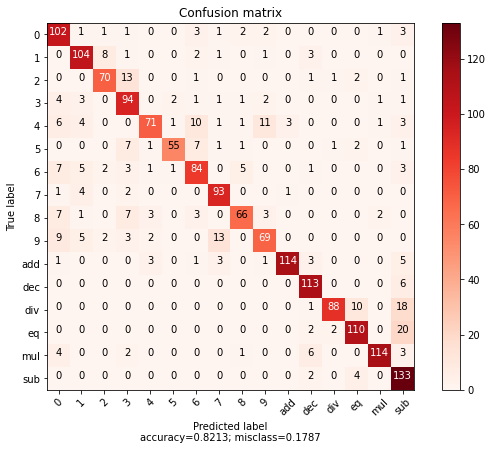

In [9]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

y_pred = model.predict(x_test.reshape(len(x_test), 30, 30, 1))

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = y_test

cm = confusion_matrix(true_categories,predicted_categories)
plot_confusion_matrix(cm, classes, normalize=False)


Classification Report

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       117
           1       0.82      0.87      0.84       120
           2       0.84      0.79      0.81        89
           3       0.71      0.85      0.77       110
           4       0.88      0.63      0.74       112
           5       0.93      0.72      0.81        76
           6       0.75      0.75      0.75       112
           7       0.82      0.92      0.87       101
           8       0.86      0.72      0.78        92
           9       0.78      0.67      0.72       103
          10       0.97      0.87      0.92       131
          11       0.86      0.95      0.90       119
          12       0.96      0.75      0.84       117
          13       0.86      0.82      0.84       134
          14       0.96      0.88      0.92       130
          15       0.68      0.96      0.79       139

    accuracy                           0.82      1802
  

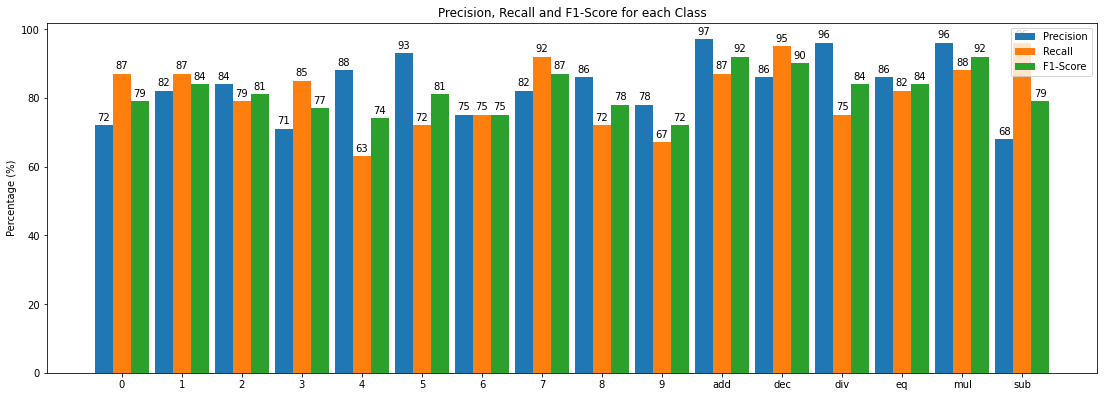

In [10]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
print('\nClassification Report\n')

cr = classification_report(true_categories, predicted_categories)
print(cr)



labels = classes
precision_score = np.round(precision_score(true_categories, predicted_categories, average=None),2)
recall_score = np.round(recall_score(true_categories, predicted_categories, average=None),2)
f1_score = np.round(f1_score(true_categories, predicted_categories, average=None),2)

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision_score*100, width, label='Precision')
rects2 = ax.bar(x , recall_score*100, width, label='Recall')
rects3 = ax.bar(x + width, f1_score*100, width, label='F1-Score')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage (%)')
ax.set_title('Precision, Recall and F1-Score for each Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()
fig.set_size_inches(17, 6, forward=True)
